<a href="https://colab.research.google.com/github/shysai/StatAn_ml/blob/main/site/en/hub/tutorials/movenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Colab-ready "Statistical Analyzer Poster" pipeline
# - Upload a CSV via Colab upload dialog (or set file_path to a Drive/local file).
# - Produces dataset summary, numeric/categorical stats, extra metrics, 6+ colorful charts (each as a separate figure),
#   auto key findings, and an A3/A4 printable poster (PNG + PDF).
# - Uses Matplotlib (no seaborn) and saves outputs to /mnt/data/stat_analyzer_outputs
#
# How to use in Colab:
# 1) Paste this whole cell into a Colab notebook.
# 2) Run the cell. When upload dialog appears, choose your CSV. If not using Colab, it'll fall back to a demo dataset.
# 3) After run, download poster and artifact files from printed paths or the Colab Files pane.
#
# Notes: User explicitly requested colorful charts, so this script sets a palette. All plots are generated as
# distinct matplotlib figures (no combined subplots for different charts).

import os, math, io, warnings
from collections import Counter
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import cm
from matplotlib.colors import to_hex
warnings.filterwarnings("ignore", category=UserWarning)

OUTPUT_DIR = "/mnt/data/stat_analyzer_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
DEMO_DATA_NAME = "demo_iris"  # fallback dataset if no upload

def colab_upload_dialog():
    """If running in Google Colab, prompt user to upload a CSV and return its filename."""
    try:
        from google.colab import files
    except Exception:
        return None
    uploaded = files.upload()
    if not uploaded:
        return None
    name = list(uploaded.keys())[0]
    # file saved in current working dir; return name
    return name

def load_csv(file_path=None, use_colab_upload=True):
    """Load CSV via file_path or Colab upload; fallback to demo Iris dataset"""
    if file_path and os.path.exists(file_path):
        df = pd.read_csv(file_path)
        source = file_path
        return df, source
    if use_colab_upload:
        uploaded = colab_upload_dialog()
        if uploaded and os.path.exists(uploaded):
            # attempt to read, with encoding fallbacks
            try:
                df = pd.read_csv(uploaded)
            except Exception:
                df = pd.read_csv(uploaded, encoding='latin1', errors='replace')
            return df, uploaded
    # fallback demo dataset (Iris)
    from sklearn.datasets import load_iris
    iris = load_iris(as_frame=True)
    df = iris.frame.copy()
    df.rename(columns={'target':'species'}, inplace=True)
    # add a date column for demonstrating line charts
    df['date_demo'] = pd.date_range(end=pd.Timestamp.today(), periods=len(df))
    return df, DEMO_DATA_NAME

def detect_column_types(df, max_cardinality_as_cat=50):
    """Return numeric, categorical, datetime columns and a cleaned dataframe with parsed datetimes."""
    df = df.copy()
    # strip column names
    df.columns = [str(c).strip() for c in df.columns]
    # Try parsing object columns to datetime if many parseable entries
    for c in df.select_dtypes(include=['object']).columns:
        sample = df[c].dropna().astype(str).head(200)
        if sample.shape[0] < 3:
            continue
        parsed = pd.to_datetime(sample, errors='coerce', infer_datetime_format=True)
        if parsed.notna().sum() >= max(3, int(0.3*len(sample))):
            df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()
    # categorical = object + category + low-cardinality numbers
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for c in numeric_cols:
        if df[c].nunique(dropna=True) <= max_cardinality_as_cat:
            cat_cols.append(c)
    # dedupe lists and return
    cat_cols = list(dict.fromkeys(cat_cols))
    return numeric_cols, cat_cols, datetime_cols, df

def numeric_statistics(df, numeric_cols):
    rows = []
    for c in numeric_cols:
        s = df[c]
        non_null = s.dropna()
        n = int(non_null.shape[0])
        missing = int(s.isna().sum())
        if n==0:
            rows.append({
                "column": c, "count": 0, "missing": missing,
                "mean": np.nan, "median": np.nan, "mode": np.nan,
                "min": np.nan, "max": np.nan, "range": np.nan,
                "std": np.nan, "var": np.nan, "skew": np.nan, "kurtosis": np.nan,
                "q25": np.nan, "q75": np.nan, "iqr": np.nan, "coef_var": np.nan,
                "outliers_iqr": 0, "outliers_zscore": 0
            })
            continue
        mean = non_null.mean()
        median = non_null.median()
        mode_vals = non_null.mode().tolist()
        mode = mode_vals[0] if len(mode_vals)>0 else np.nan
        mn = non_null.min(); mx = non_null.max(); rng = mx - mn
        std = non_null.std(ddof=1); var = non_null.var(ddof=1)
        skew = non_null.skew(); kurt = non_null.kurtosis()
        q25 = non_null.quantile(0.25); q75 = non_null.quantile(0.75); iqr = q75 - q25
        # outlier counts via IQR rule and z-score rule
        lower, upper = q25 - 1.5*iqr, q75 + 1.5*iqr
        out_iqr = int(non_null[(non_null < lower) | (non_null > upper)].shape[0])
        # z-score outliers (abs z > 3)
        if std == 0 or np.isnan(std):
            out_z = 0
        else:
            z = (non_null - mean) / std
            out_z = int((z.abs() > 3).sum())
        coef_var = std/mean if mean != 0 else np.nan
        rows.append({
            "column": c, "count": n, "missing": missing,
            "mean": mean, "median": median, "mode": mode,
            "min": mn, "max": mx, "range": rng,
            "std": std, "var": var, "skew": skew, "kurtosis": kurt,
            "q25": q25, "q75": q75, "iqr": iqr, "coef_var": coef_var,
            "outliers_iqr": out_iqr, "outliers_zscore": out_z
        })
    stats_num = pd.DataFrame(rows).set_index("column")
    return stats_num

def categorical_summary(df, cat_cols, top_k=5):
    rows = []
    for c in cat_cols:
        s = df[c].astype(object)
        vc = s.value_counts(dropna=False)
        top = vc.head(top_k).to_dict()
        rows.append({
            "column": c,
            "unique": int(s.nunique(dropna=True)),
            "missing": int(s.isna().sum()),
            "top_values": top
        })
    cat_df = pd.DataFrame(rows).set_index("column") if rows else pd.DataFrame()
    return cat_df

# Helpers for colorful palette
def get_palette(n):
    cmap = cm.get_cmap('tab20')  # stable categorical palette
    colors = [to_hex(cmap(i)) for i in range(n)]
    return colors

def save_fig(fig, fname, dpi=150):
    path = os.path.join(OUTPUT_DIR, fname)
    fig.savefig(path, dpi=dpi, bbox_inches='tight')
    plt.close(fig)
    return path

# Individual chart creators: each makes a separate matplotlib figure
def plot_histogram(df, col, bins=30):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    data = df[col].dropna()
    colors = get_palette(6)
    ax.hist(data, bins=bins, edgecolor='black', color=colors[0])
    ax.set_title(f"Histogram — {col}", fontsize=12)
    ax.set_xlabel(col); ax.set_ylabel("Frequency")
    return save_fig(fig, f"hist_{col}.png")

def plot_bar_chart(df, col, top_n=12):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    vc = df[col].astype(str).value_counts().nlargest(top_n)
    colors = get_palette(vc.shape[0])
    ax.bar(vc.index.astype(str), vc.values, edgecolor='black', color=colors)
    ax.set_xticklabels([str(x) for x in vc.index], rotation=45, ha='right')
    ax.set_title(f"Bar Chart — {col}", fontsize=12)
    ax.set_ylabel("Count")
    return save_fig(fig, f"bar_{col}.png")

def plot_pie_chart(df, col, top_n=8):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    vc = df[col].astype(str).value_counts()
    if vc.shape[0] > top_n:
        top = vc.nlargest(top_n-1)
        other = vc.iloc[top_n-1:].sum()
        top['Other'] = other
        vc = top
    colors = get_palette(vc.shape[0])
    ax.pie(vc.values, labels=[str(x) for x in vc.index], autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(f"Pie Chart — {col}", fontsize=12)
    return save_fig(fig, f"pie_{col}.png")

def plot_boxplot(df, col):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    data = df[col].dropna()
    ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=get_palette(1)[0], color='black'))
    ax.set_title(f"Boxplot — {col}", fontsize=12)
    return save_fig(fig, f"box_{col}.png")

def plot_line_chart(df, dt_col, num_col, freq='D'):
    # aggregate by date freq and plot
    tmp = df[[dt_col, num_col]].dropna().copy()
    tmp = tmp.groupby(pd.Grouper(key=dt_col, freq=freq))[num_col].mean().reset_index()
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    ax.plot(tmp[dt_col], tmp[num_col], marker='o', linestyle='-', linewidth=1, markersize=3)
    ax.set_title(f"Line Chart — {num_col} over {dt_col}", fontsize=12)
    ax.set_xlabel("Date"); ax.set_ylabel(num_col)
    return save_fig(fig, f"line_{num_col}_by_{dt_col}.png")

def plot_scatter(df, xcol, ycol):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.scatter(df[xcol], df[ycol], alpha=0.7, edgecolors='w', s=40, c=get_palette(1)[0])
    ax.set_xlabel(xcol); ax.set_ylabel(ycol)
    ax.set_title(f"Scatter — {ycol} vs {xcol}", fontsize=12)
    return save_fig(fig, f"scatter_{xcol}_vs_{ycol}.png")

def plot_corr_heatmap(df, numeric_cols):
    # correlation matrix (pearson) - limited to 12 columns for readability
    cols = numeric_cols[:12]
    corr = df[cols].corr().fillna(0)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(len(cols))); ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)
    ax.set_title("Correlation matrix (Pearson) — top numeric cols", fontsize=12)
    # colorbar
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    return save_fig(fig, "corr_matrix.png"), corr

# Poster assembler — composes the images and textual blocks into one printable PNG + PDF for A3/A4
from PIL import Image, ImageDraw, ImageFont

def assemble_poster(dataset_name, dataset_source, summary_text, sample_df, stats_num_df, cat_summary_df, visuals, findings, poster_size='A3'):
    # poster layout using PIL for stable placement, then save PNG and PDF at high dpi
    # poster_size: 'A3' or 'A4' (portrait)
    if poster_size == 'A3':
        dpi = 300
        width_in, height_in = 11.69, 16.54  # A3 portrait (inches)
    else:
        dpi = 300
        width_in, height_in = 8.27, 11.69  # A4 portrait
    W, H = int(width_in * dpi), int(height_in * dpi)
    poster = Image.new('RGB', (W, H), color='white')
    draw = ImageDraw.Draw(poster)
    # Fonts (default fallback)
    try:
        font_title = ImageFont.truetype("DejaVuSans-Bold.ttf", size=48)
        font_h = ImageFont.truetype("DejaVuSans-Bold.ttf", size=28)
        font_body = ImageFont.truetype("DejaVuSans.ttf", size=20)
        font_mono = ImageFont.truetype("DejaVuSansMono.ttf", size=18)
    except Exception:
        font_title = font_h = font_body = font_mono = None
    # Header
    header_text = f"Statistical Analyzer Poster — {dataset_name}"
    draw.text((int(0.035*W), int(0.025*H)), header_text, fill='black', font=font_title)
    draw.text((int(0.035*W), int(0.09*H)), f"Source: {dataset_source}    Tools: pandas, numpy, matplotlib", fill='black', font=font_body)
    # Left column: summary and small sample (text)
    left_x = int(0.035*W); left_w = int(0.45*W)
    y = int(0.13*H)
    # summary text block
    for i, line in enumerate(summary_text.splitlines()):
        draw.text((left_x, y + i*28), line, fill='black', font=font_body)
    y += 180
    # sample table (render as text rows)
    sample_str = sample_df.head(6).to_string(index=False)
    for i, line in enumerate(sample_str.splitlines()):
        draw.text((left_x, y + i*22), line, fill='black', font=font_mono)
    y += 160
    # basic stats preview (first 6 numeric rows)
    stats_preview = stats_num_df.round(4).head(6).to_string()
    draw.text((left_x, y), "Basic statistics (preview):", fill='black', font=font_h)
    y += 40
    for i, line in enumerate(stats_preview.splitlines()):
        draw.text((left_x, y + i*20), line, fill='black', font=font_mono)
    # Right column: visuals (thumbnail images)
    thumb_w = int(0.45*W); thumb_x = int(0.52*W)
    # place up to 6 visuals vertically
    vis_files = [v for v in visuals if v is not None][:6]
    thumb_h = int((H - int(0.15*H)) / len(vis_files)) if vis_files else 0
    yv = int(0.13*H)
    for vf in vis_files:
        try:
            im = Image.open(vf)
            im.thumbnail((thumb_w-40, thumb_h-40))
            poster.paste(im, (thumb_x + 10, yv + 10))
        except Exception:
            pass
        yv += thumb_h
    # Key findings bottom
    yf = int(0.65*H)
    draw.text((left_x, yf), "Key Findings:", fill='black', font=font_h)
    yf += 40
    for i, f in enumerate(findings):
        draw.text((left_x, yf + i*28), f"- {f}", fill='black', font=font_body)
    # Save poster
    png_path = os.path.join(OUTPUT_DIR, f"statistical_poster_{poster_size}.png")
    pdf_path = os.path.join(OUTPUT_DIR, f"statistical_poster_{poster_size}.pdf")
    poster.save(png_path, dpi=(dpi, dpi))
    poster.save(pdf_path, dpi=(dpi, dpi))
    return png_path, pdf_path

# Main orchestration function
def analyze_and_create(file_path=None, poster_size='A3'):
    df, source = load_csv(file_path=file_path, use_colab_upload=True)
    print(f"Loaded dataset: {source} — shape: {df.shape}")
    numeric_cols, cat_cols, datetime_cols, df = detect_column_types(df)
    print("Detected column types:")
    print(f"Numeric: {numeric_cols}\nCategorical: {cat_cols}\nDatetime: {datetime_cols}\n")
    # Basic dataset summary
    dataset_name = os.path.splitext(os.path.basename(source))[0] if source != DEMO_DATA_NAME else "Iris (demo)"
    dataset_source = source
    summary_text = f"Rows: {df.shape[0]}    Columns: {df.shape[1]}\nMissing overall: {df.isna().sum().sum()}/{df.size} ({(df.isna().sum().sum()/df.size*100):.2f}%)\nDetected types: {', '.join([f'{k}: {v}' for k,v in df.dtypes.apply(lambda x: x.name).value_counts().to_dict().items()])}"
    # Stats
    stats_num = numeric_statistics(df, numeric_cols) if numeric_cols else pd.DataFrame()
    cat_summary = categorical_summary(df, cat_cols) if cat_cols else pd.DataFrame()
    # Save stats to CSV for submission
    stats_csv = os.path.join(OUTPUT_DIR, "numeric_stats.csv")
    cat_csv = os.path.join(OUTPUT_DIR, "categorical_summary.csv")
    stats_num.to_csv(stats_csv)
    cat_summary.to_csv(cat_csv)
    # Extra metrics: correlations (and heatmap)
    corr_path, corr_df = (None, None)
    if len(numeric_cols) >= 2:
        corr_path, corr_df = plot_corr_heatmap(df, numeric_cols)
        corr_df.to_csv(os.path.join(OUTPUT_DIR, "correlation_matrix.csv"))
    # Choose visuals automatically (robust selection)
    visuals = []
    # Histograms: up to 3 numeric cols by variance
    if numeric_cols:
        variances = [(c, df[c].var()) for c in numeric_cols]
        variances.sort(key=lambda x: - (x[1] if not pd.isna(x[1]) else -1))
        hist_cols = [c for c,_ in variances[:3]]
        for c in hist_cols:
            path = plot_histogram(df, c)
            visuals.append(path)
    # Bar & Pie: choose categorical with reasonable cardinality (5..40) and most non-null
    chosen_cat = None
    if cat_cols:
        cand = []
        for c in cat_cols:
            uniq = df[c].nunique(dropna=True)
            non_null = df[c].notna().sum()
            cand.append((c, non_null, uniq))
        cand.sort(key=lambda x: (-x[1], x[2]))
        for c, nn, uniq in cand:
            if 2 <= uniq <= 100:
                chosen_cat = c
                break
        if chosen_cat is None and cat_cols:
            chosen_cat = cat_cols[0]
    if chosen_cat:
        visuals.append(plot_bar_chart(df, chosen_cat))
        visuals.append(plot_pie_chart(df, chosen_cat))
    # Boxplot for highest-skew numeric
    if numeric_cols:
        skewed = sorted(numeric_cols, key=lambda c: abs(df[c].dropna().skew() if df[c].dropna().shape[0]>0 else 0), reverse=True)
        visuals.append(plot_boxplot(df, skewed[0]))
    # Line chart: if datetime exists + numeric
    if datetime_cols and numeric_cols:
        visuals.append(plot_line_chart(df, datetime_cols[0], numeric_cols[0]))
    else:
        # fallback: line of first numeric by index
        if numeric_cols:
            # create simple line plot of index vs numeric (saved)
            col = numeric_cols[0]
            fig = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(111)
            ax.plot(df.index, df[col], marker='.', linestyle='-', linewidth=0.8)
            ax.set_title(f"Line — index vs {col}")
            ax.set_xlabel("Index"); ax.set_ylabel(col)
            visuals.append(save_fig(fig, f"line_index_{col}.png"))
    # Scatter: choose two numeric cols with highest absolute correlation if available
    if len(numeric_cols) >= 2:
        corrmat = df[numeric_cols].corr().abs().fillna(0)
        # find pair (i,j) with max corr off-diagonal
        idx = np.unravel_index(np.argmax(corrmat.values + np.eye(corrmat.shape[0])* -1), corrmat.shape)
        xcol, ycol = corrmat.columns[idx[0]], corrmat.columns[idx[1]]
        if xcol == ycol and len(numeric_cols) > 1:
            xcol, ycol = numeric_cols[0], numeric_cols[1]
        visuals.append(plot_scatter(df, xcol, ycol))
    # Correlation heatmap already appended earlier via corr_path
    if corr_path:
        visuals.append(corr_path)
    # Generate Key Findings automatically (shortlist 4-6)
    findings = []
    # 1. Most frequent category summary
    if chosen_cat:
        vc = df[chosen_cat].astype(str).value_counts(dropna=True)
        top1 = vc.index[0]; top1c = int(vc.iloc[0])
        findings.append(f"Top category in '{chosen_cat}': '{top1}' ({top1c} rows, {(top1c/df.shape[0]*100):.1f}%).")
    # 2. Numeric concentration
    if not stats_num.empty:
        top_num = stats_num.sort_values("count", ascending=False).index[0]
        mean = stats_num.loc[top_num,"mean"]; median = stats_num.loc[top_num,"median"]
        q5 = df[top_num].quantile(0.05); q95 = df[top_num].quantile(0.95)
        findings.append(f"Numeric '{top_num}': mean={mean:.3g}, median={median:.3g}. 5–95% range ≈ [{q5:.3g}, {q95:.3g}].")
        # outliers
        out_iqr = int(stats_num.loc[top_num,"outliers_iqr"])
        findings.append(f"Outliers (IQR rule) in '{top_num}': {out_iqr} observations.")
    # 3. Missingness
    miss_pct = df.isna().sum().sum() / df.size * 100 if df.size>0 else 0
    findings.append(f"Overall missingness: {miss_pct:.2f}% of cells.")
    # 4. High-cardinality columns
    high_card = [c for c in df.columns if df[c].nunique(dropna=True) > min(0.5*df.shape[0], 100)]
    if high_card:
        findings.append("High-cardinality columns: " + ", ".join(high_card[:5]))
    # 5. Correlation highlight
    if corr_df is not None:
        # find strongest correlation pair
        corr_abs = corr_df.abs().where(~np.eye(corr_df.shape[0],dtype=bool)).stack()
        if not corr_abs.empty:
            top_pair = corr_abs.idxmax(); top_val = corr_abs.max()
            findings.append(f"Strongest Pearson correlation: {top_pair[0]} ↔ {top_pair[1]} = {top_val:.2f}")
    # assemble poster
    sample_df = df.head(6)
    poster_png, poster_pdf = assemble_poster(dataset_name, dataset_source, summary_text, sample_df, stats_num, cat_summary, visuals, findings, poster_size=poster_size)
    # print artifact paths to user
    print("\n=== Outputs saved to:", OUTPUT_DIR, "===\n")
    print("Poster PNG:", poster_png)
    print("Poster PDF:", poster_pdf)
    print("Numeric stats CSV:", stats_csv)
    print("Categorical summary CSV:", cat_csv)
    if corr_path:
        print("Correlation heatmap:", corr_path)
    print("\nGenerated visuals:")
    for v in visuals:
        print("-", v)
    print("\nAuto key findings:")
    for f in findings:
        print("-", f)
    return {
        "poster_png": poster_png,
        "poster_pdf": poster_pdf,
        "numeric_stats_csv": stats_csv,
        "categorical_summary_csv": cat_csv,
        "visuals": visuals,
        "key_findings": findings
    }

# Run analysis: in Colab this will prompt upload. If not in Colab, falls back to demo dataset.
results = analyze_and_create(file_path=None, poster_size='A3')

# Provide helpful download-style hints for Colab users
print("\nIf you're in Colab: use the Files sidebar or the printed paths above to download poster and CSVs.")
print("Example: from google.colab import files; files.download('{}')".format(results['poster_pdf']))


Saving adult[1].csv to adult[1].csv
Loaded dataset: adult[1].csv — shape: (32561, 15)
Detected column types:
Numeric: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
Categorical: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income', 'education.num']
Datetime: []



/tmp/ipython-input-1751322327.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # stable categorical palette
/tmp/ipython-input-1751322327.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # stable categorical palette
/tmp/ipython-input-1751322327.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20')  # stable categorical palette
/tmp/ipython-input-1751322327.py:151: Ma


=== Outputs saved to: /mnt/data/stat_analyzer_outputs ===

Poster PNG: /mnt/data/stat_analyzer_outputs/statistical_poster_A3.png
Poster PDF: /mnt/data/stat_analyzer_outputs/statistical_poster_A3.pdf
Numeric stats CSV: /mnt/data/stat_analyzer_outputs/numeric_stats.csv
Categorical summary CSV: /mnt/data/stat_analyzer_outputs/categorical_summary.csv
Correlation heatmap: /mnt/data/stat_analyzer_outputs/corr_matrix.png

Generated visuals:
- /mnt/data/stat_analyzer_outputs/hist_fnlwgt.png
- /mnt/data/stat_analyzer_outputs/hist_capital.gain.png
- /mnt/data/stat_analyzer_outputs/hist_capital.loss.png
- /mnt/data/stat_analyzer_outputs/bar_sex.png
- /mnt/data/stat_analyzer_outputs/pie_sex.png
- /mnt/data/stat_analyzer_outputs/box_capital.gain.png
- /mnt/data/stat_analyzer_outputs/line_index_age.png
- /mnt/data/stat_analyzer_outputs/scatter_education.num_vs_hours.per.week.png
- /mnt/data/stat_analyzer_outputs/corr_matrix.png

Auto key findings:
- Top category in 'sex': 'Male' (21790 rows, 66.9%)

Saving adult.csv.zip to adult.csv.zip
Loaded: adult.csv.zip shape: (32561, 15)

Detected types:
Numeric: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'] 
Categorical: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income', 'education.num'] 
Datetime: []

Overall missing: 4262 / 488415 cells (0.87%)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K


,count,missing,mean,median,mode,min,max,range,std,var,...,kurtosis,q05,q25,q75,q95,iqr,jb_stat,jb_pvalue,outliers_iqr,outliers_zscore
column,,,,,,,,,,,,,,,,,,,,,
age,32561,0,38.581647,37.0,36,17,90,73,13.640433,1.860614e+02,...,-0.166127,19.0,28.0,48.0,63.0,20.0,1.731584e+03,0.000000e+00,143,121
fnlwgt,32561,0,189778.366512,178356.0,123011,12285,1484705,1472420,105549.977697,1.114080e+10,...,6.218811,39460.0,117827.0,237051.0,379682.0,119224.0,6.381098e+04,0.000000e+00,992,347
education.num,32561,0,10.080679,10.0,9,1,16,15,2.572720,6.618890e+00,...,0.623444,5.0,9.0,12.0,14.0,3.0,1.053979e+03,1.353018e-229,1198,219
capital.gain,32561,0,1077.648844,0.0,0,0,99999,99999,7385.292085,5.454254e+07,...,154.799438,0.0,0.0,0.0,5013.0,0.0,3.327595e+07,0.000000e+00,2712,215
capital.loss,32561,0,87.303830,0.0,0,0,4356,4356,402.960219,1.623769e+05,...,20.376802,0.0,0.0,0.0,0.0,0.0,6.776944e+05,0.000000e+00,1519,1470
hours.per.week,32561,0,40.437456,40.0,40,1,99,98,12.347429,1.524590e+02,...,2.916687,18.0,40.0,45.0,60.0,5.0,1.181780e+04,0.000000e+00,9008,440


,unique,missing,top_values
column,,,
workclass,8,1836,"{'Private': 22696, 'Self-emp-not-inc': 2541, '..."
education,16,0,"{'HS-grad': 10501, 'Some-college': 7291, 'Bach..."
marital.status,7,0,"{'Married-civ-spouse': 14976, 'Never-married':..."
occupation,14,1843,"{'Prof-specialty': 4140, 'Craft-repair': 4099,..."
relationship,6,0,"{'Husband': 13193, 'Not-in-family': 8305, 'Own..."
race,5,0,"{'White': 27816, 'Black': 3124, 'Asian-Pac-Isl..."
sex,2,0,"{'Male': 21790, 'Female': 10771}"
native.country,41,583,"{'United-States': 29170, 'Mexico': 643, nan: 5..."
income,2,0,"{'<=50K': 24720, '>50K': 7841}"


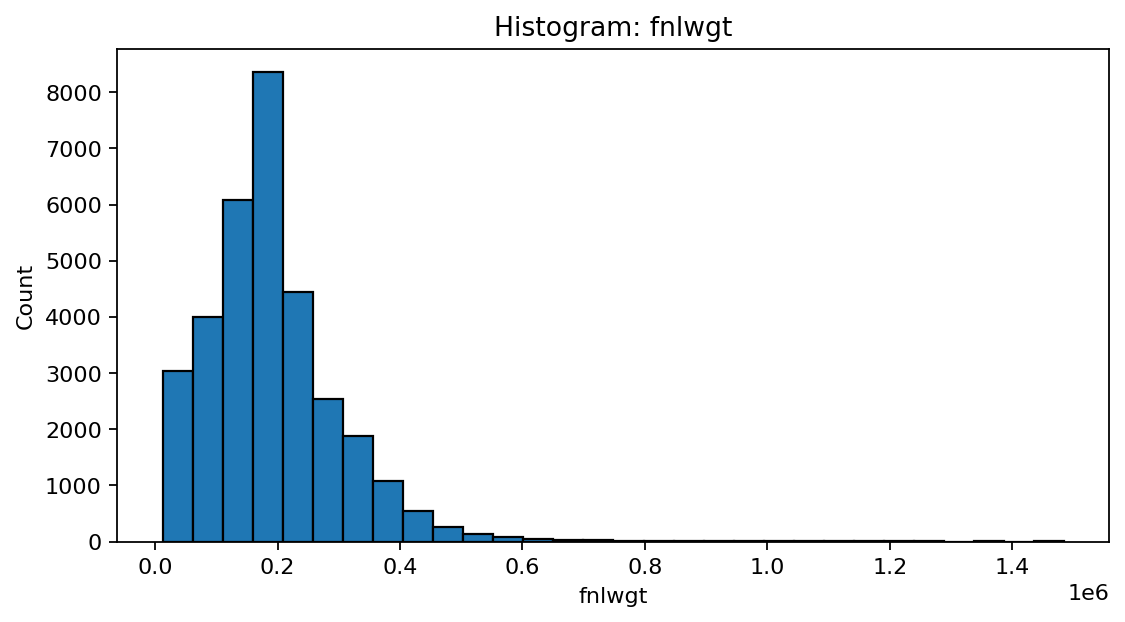

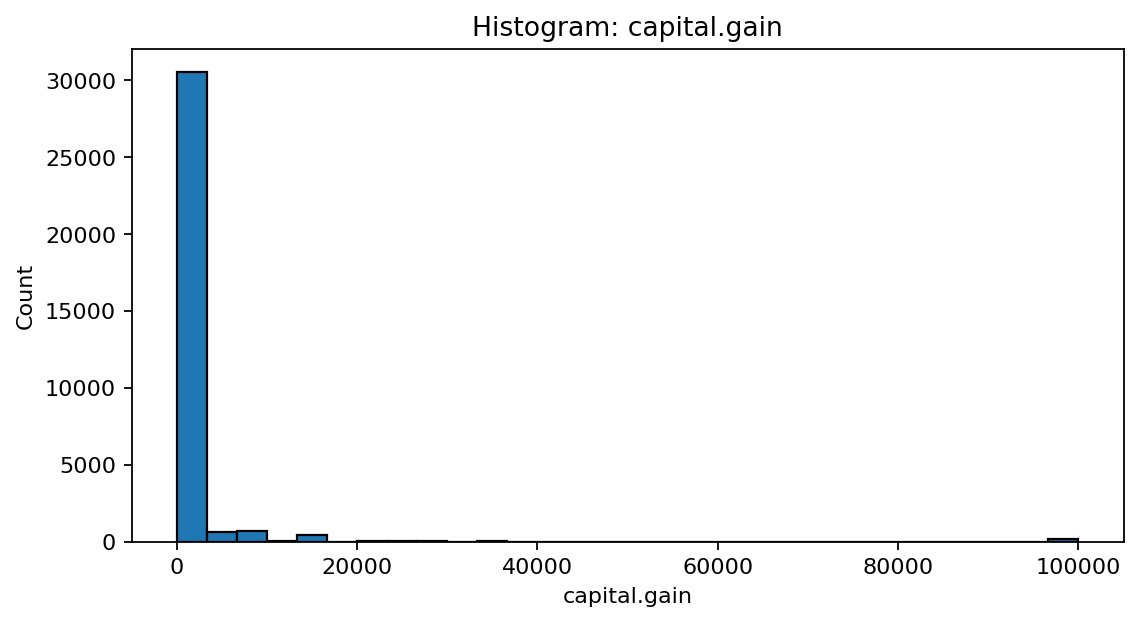

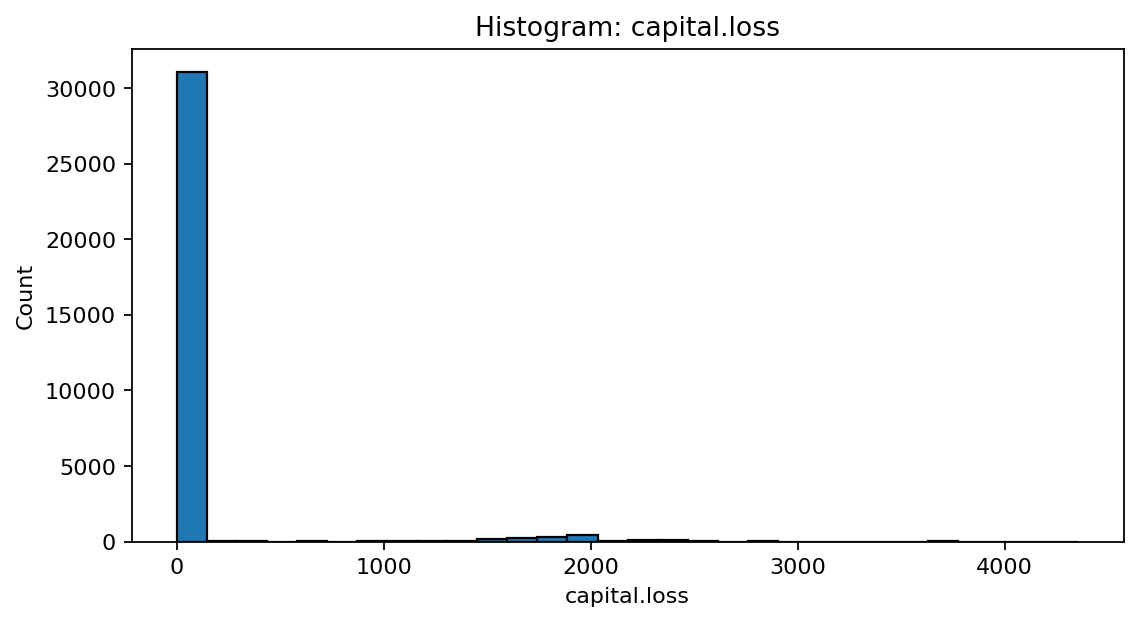

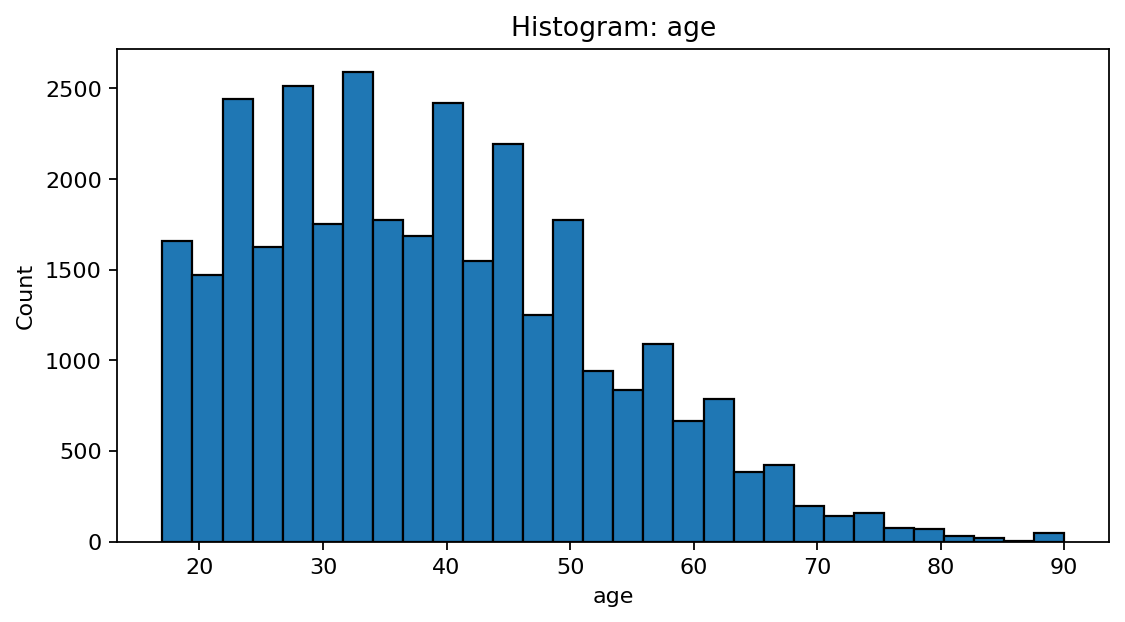

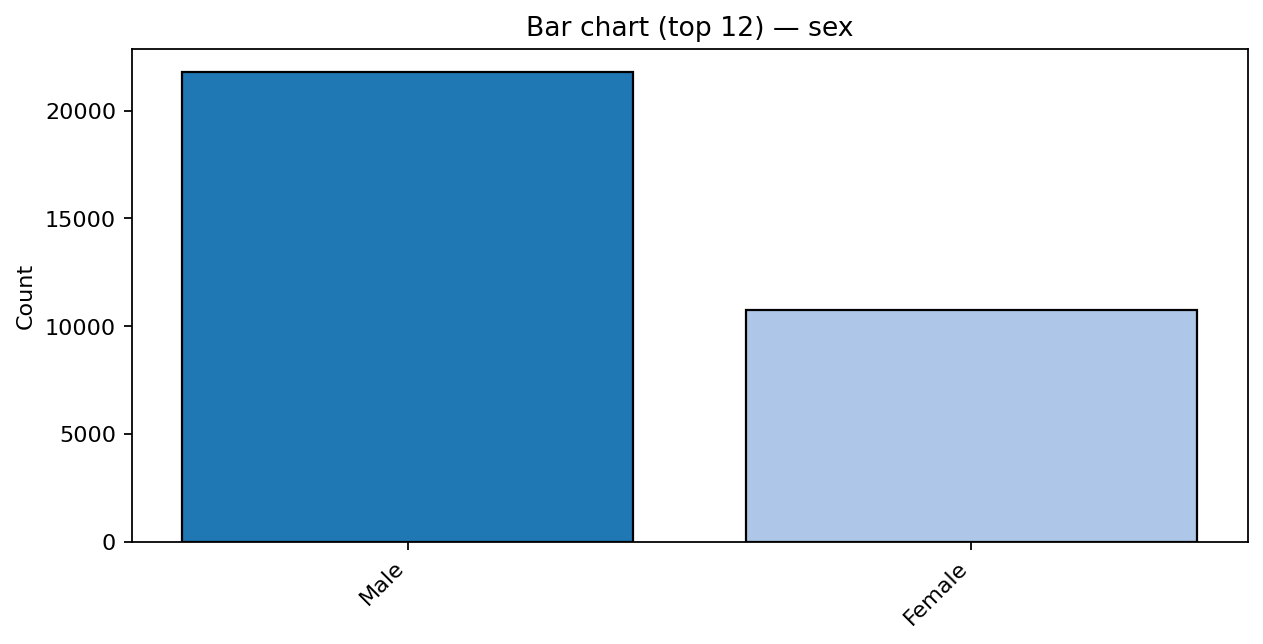

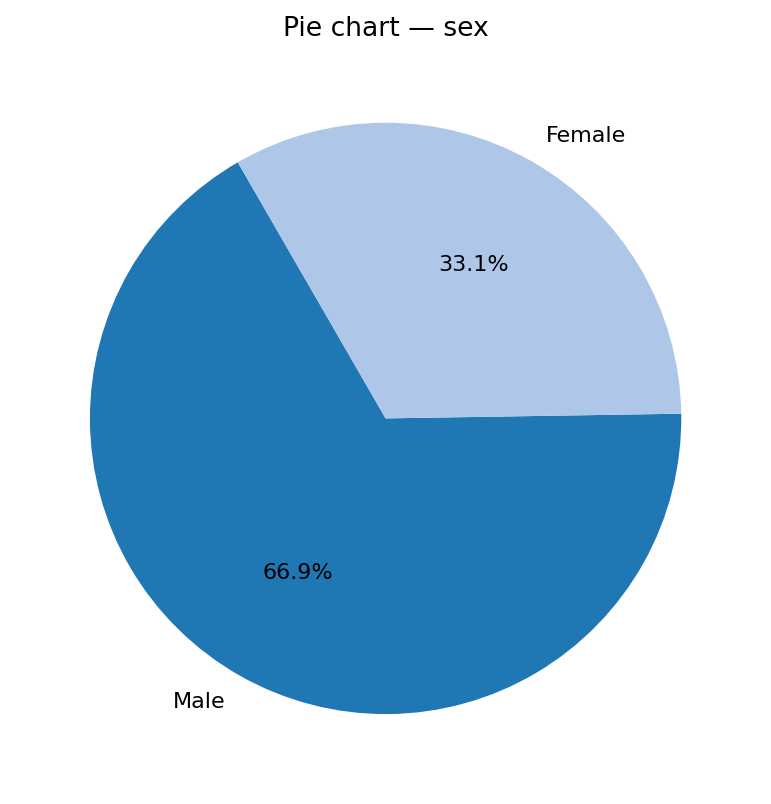

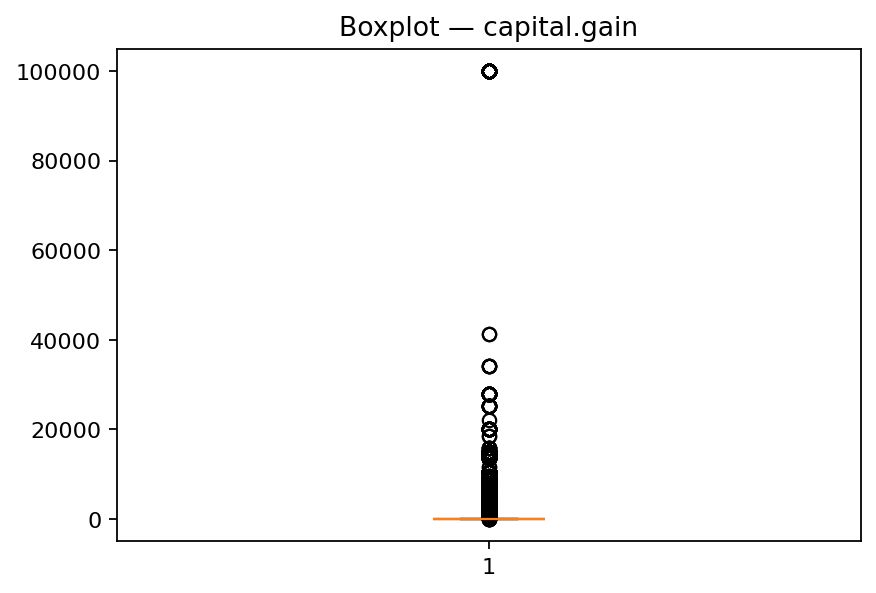

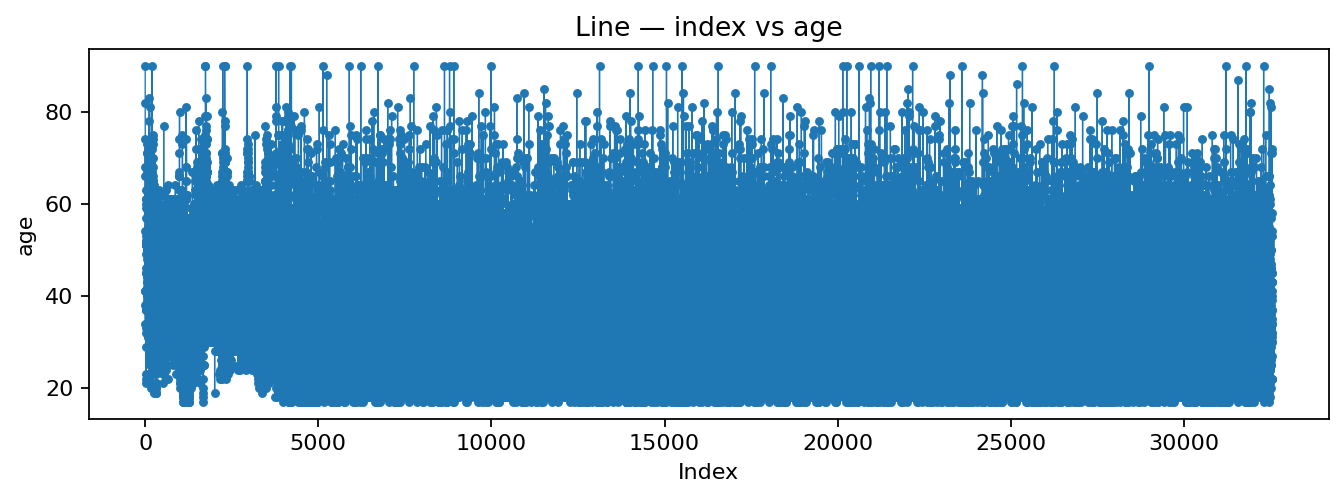

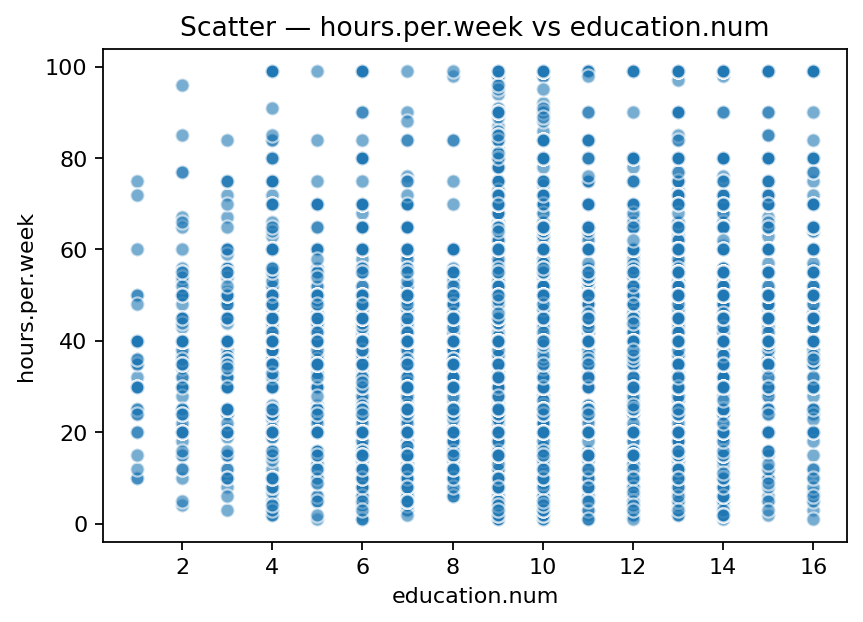

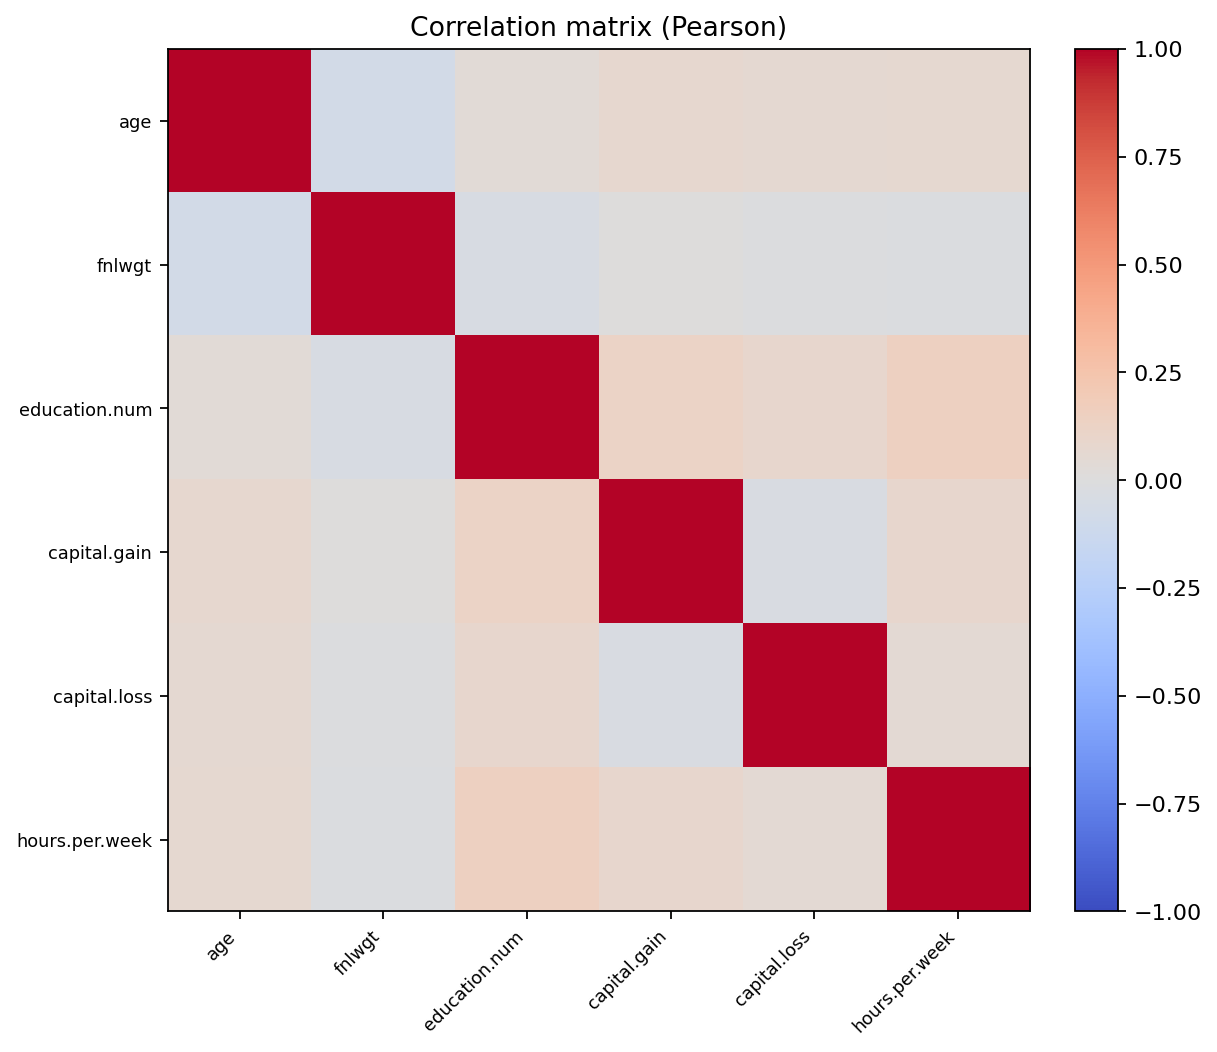

,binary_col,numeric_col,test,stat,pvalue,n_group0,n_group1
0,sex,age,Mann-Whitney U,102899833.5,2.573401e-73,10771,21790
1,sex,fnlwgt,Mann-Whitney U,113738782.0,6.033919e-06,10771,21790
2,sex,education.num,Mann-Whitney U,116467979.0,2.568970e-01,10771,21790
3,sex,capital.gain,Mann-Whitney U,112751132.5,2.598583e-33,10771,21790
4,sex,capital.loss,Mann-Whitney U,115131919.0,2.816660e-14,10771,21790
5,sex,hours.per.week,Mann-Whitney U,81220284.0,0.000000e+00,10771,21790
6,income,age,Mann-Whitney U,61203011.5,0.000000e+00,24720,7841
7,income,fnlwgt,Mann-Whitney U,98319904.5,5.268194e-02,24720,7841
8,income,education.num,Mann-Whitney U,54854450.5,0.000000e+00,24720,7841
9,income,capital.gain,Mann-Whitney U,79471483.0,0.000000e+00,24720,7841


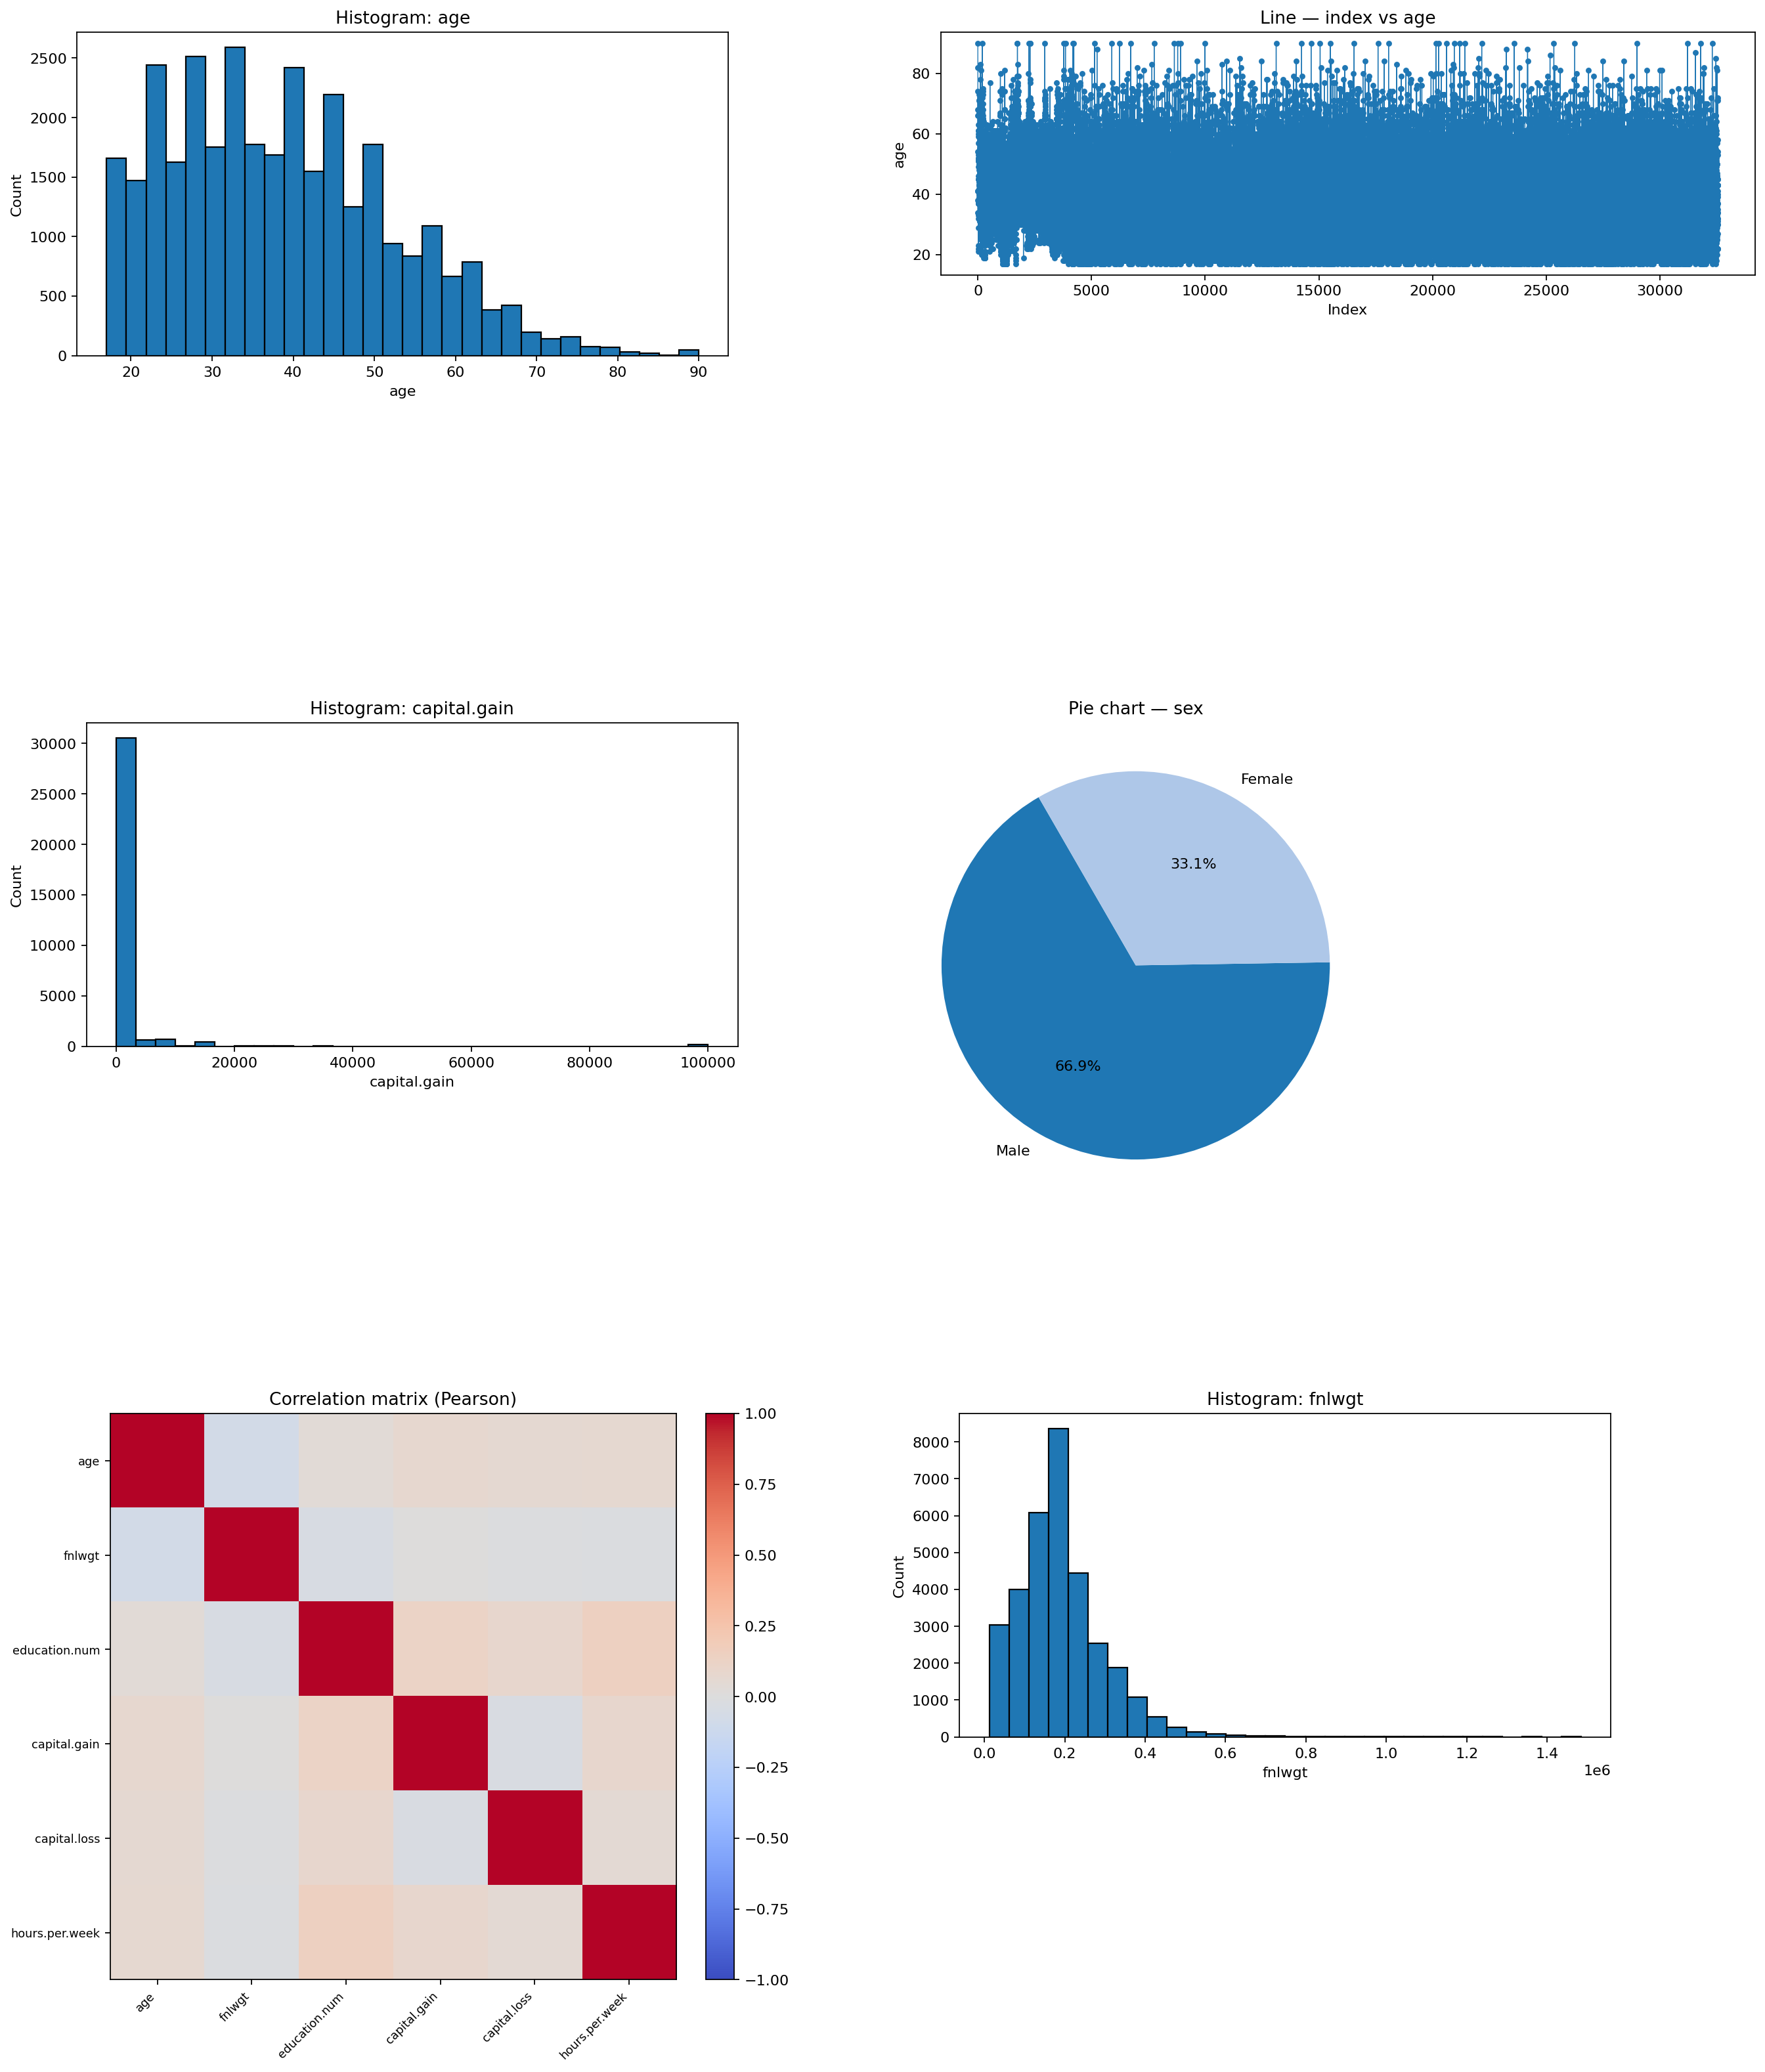


Artifacts saved to: /mnt/data/stat_analyzer_outputs
- bar_sex.png
- box_capital.gain.png
- categorical_summary.csv
- corr_matrix.png
- correlation_matrix.csv
- group_tests.csv
- hist_age.png
- hist_capital.gain.png
- hist_capital.loss.png
- hist_fnlwgt.png
- line_index_age.png
- numeric_stats.csv
- pie_sex.png
- poster_thumbnails.png
- scatter_education.num_vs_hours.per.week.png
- statistical_poster_A3.pdf
- statistical_poster_A3.png


In [4]:
# Colab-ready: Improved Statistical Analyzer for adult[1].csv (or any CSV)
# - Handles '?' as missing, strips whitespace, converts numeric-like strings.
# - Displays all plots inline AND saves them to /mnt/data/stat_analyzer_outputs
# - Adds extra stats: Jarque-Bera normality, Pearson+Spearman, Cramér's V, group tests.
# - Exports CSVs + poster-ready artifacts.
# Usage: paste into a Colab cell and run. When prompted, upload your CSV.

import os, math, warnings
from collections import Counter
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display, Image as IPyImage, HTML
from PIL import Image as PILImage
warnings.filterwarnings("ignore")

# stats
from scipy import stats
from scipy.stats import chi2_contingency, jarque_bera, ttest_ind, mannwhitneyu, levene

OUTPUT_DIR = "/mnt/data/stat_analyzer_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- helper functions ----------
def colab_upload():
    try:
        from google.colab import files
    except Exception:
        return None
    uploaded = files.upload()
    if not uploaded:
        return None
    name = list(uploaded.keys())[0]
    return name

def read_csv_handle_missing(path_or_none=None):
    if path_or_none and os.path.exists(path_or_none):
        fp = path_or_none
    else:
        uploaded = colab_upload()
        if uploaded and os.path.exists(uploaded):
            fp = uploaded
        else:
            raise FileNotFoundError("No file provided and no upload detected.")
    # treat '?' as NA, strip whitespace in object columns, use low_memory=False to avoid dtype warnings
    df = pd.read_csv(fp, na_values=['?',' ?','NA','N/A',''], keep_default_na=True, encoding='latin1', low_memory=False)
    # strip whitespace for object columns
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].astype(str).str.strip().replace({'nan': np.nan})
    # attempt numeric conversion for object cols where majority parse numeric
    for c in df.select_dtypes(include=['object']).columns:
        coerced = pd.to_numeric(df[c], errors='coerce')
        if coerced.notna().sum() >= max(3, int(0.6 * df.shape[0])):  # >=60% parseable -> convert
            df[c] = coerced
    return df, fp

def detect_types(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64[ns]','datetime64']).columns.tolist()
    # parse object->datetime heuristically
    for c in df.select_dtypes(include=['object']).columns:
        sample = df[c].dropna().astype(str).head(200)
        if len(sample) >= 5:
            parsed = pd.to_datetime(sample, errors='coerce', infer_datetime_format=True)
            if parsed.notna().sum() >= max(3, int(0.3 * len(sample))):
                df[c] = pd.to_datetime(df[c], errors='coerce', infer_datetime_format=True)
                datetime_cols.append(c)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    # consider low-cardinality numerics as categorical too (e.g., education.num sometimes)
    for c in numeric_cols:
        if df[c].nunique(dropna=True) <= 50:
            cat_cols.append(c)
    # dedupe
    cat_cols = list(dict.fromkeys(cat_cols))
    return numeric_cols, cat_cols, datetime_cols, df

def save_and_display_fig(fig, fname):
    p = os.path.join(OUTPUT_DIR, fname)
    fig.savefig(p, dpi=160, bbox_inches='tight')
    plt.close(fig)
    display(IPyImage(filename=p))
    return p

# ---------- statistical helpers ----------
def numeric_stats(df, numeric_cols):
    rows = []
    for c in numeric_cols:
        s = df[c].dropna()
        n = s.shape[0]
        if n == 0:
            continue
        mean = s.mean(); median = s.median(); mode = (s.mode().iloc[0] if not s.mode().empty else np.nan)
        mn, mx = s.min(), s.max(); rng = mx - mn
        std = s.std(ddof=1); var = s.var(ddof=1)
        skew = s.skew(); kurt = s.kurtosis()
        q05, q25, q75, q95 = s.quantile([0.05,0.25,0.75,0.95]).tolist()
        iqr = q75 - q25
        jb_stat, jb_p = jarque_bera(s)  # normality test
        # outliers
        lower, upper = q25 - 1.5 * iqr, q75 + 1.5 * iqr
        out_iqr = int(((s < lower) | (s > upper)).sum())
        # z-score outliers
        out_z = int(((np.abs((s - mean) / (std if std!=0 else 1))) > 3).sum())
        rows.append({
            'column': c, 'count': n, 'missing': int(df[c].isna().sum()),
            'mean': mean, 'median': median, 'mode': mode, 'min': mn, 'max': mx, 'range': rng,
            'std': std, 'var': var, 'skew': skew, 'kurtosis': kurt,
            'q05': q05, 'q25': q25, 'q75': q75, 'q95': q95, 'iqr': iqr,
            'jb_stat': jb_stat, 'jb_pvalue': jb_p,
            'outliers_iqr': out_iqr, 'outliers_zscore': out_z
        })
    return pd.DataFrame(rows).set_index('column')

def categorical_summary(df, cat_cols, top_k=8):
    rows = []
    for c in cat_cols:
        s = df[c].astype(object)
        vc = s.value_counts(dropna=False)
        top = vc.head(top_k).to_dict()
        rows.append({'column': c, 'unique': int(s.nunique(dropna=True)), 'missing': int(s.isna().sum()), 'top_values': top})
    return pd.DataFrame(rows).set_index('column') if rows else pd.DataFrame()

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    if confusion.size == 0:
        return np.nan
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r,k = confusion.shape
    # bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1),(rcorr-1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2corr / denom)

# ---------- plotting helpers ----------
def plot_hist(df, col, bins=30):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    data = df[col].dropna()
    cmap = plt.colormaps.get_cmap('tab10') if hasattr(plt, 'colormaps') else plt.get_cmap('tab10')
    ax.hist(data, bins=bins, edgecolor='black', color=cmap(0))
    ax.set_title(f"Histogram: {col}")
    ax.set_xlabel(col); ax.set_ylabel("Count")
    return save_and_display_fig(fig, f"hist_{col}.png")

def plot_bar(df, col, top_n=12):
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111)
    vc = df[col].astype(str).value_counts().nlargest(top_n)
    cmap = plt.colormaps.get_cmap('tab20') if hasattr(plt, 'colormaps') else plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(vc))]
    ax.bar(vc.index.astype(str), vc.values, color=colors, edgecolor='black')
    ax.set_xticklabels([str(x) for x in vc.index], rotation=45, ha='right')
    ax.set_title(f"Bar chart (top {top_n}) — {col}")
    ax.set_ylabel("Count")
    return save_and_display_fig(fig, f"bar_{col}.png")

def plot_pie(df, col, top_n=8):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    vc = df[col].astype(str).value_counts()
    if vc.shape[0] > top_n:
        top = vc.nlargest(top_n-1)
        other = vc.iloc[top_n-1:].sum()
        top['Other'] = other
        vc = top
    cmap = plt.colormaps.get_cmap('tab20') if hasattr(plt, 'colormaps') else plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(len(vc))]
    ax.pie(vc.values, labels=[str(x) for x in vc.index], autopct='%1.1f%%', colors=colors, startangle=120)
    ax.set_title(f"Pie chart — {col}")
    return save_and_display_fig(fig, f"pie_{col}.png")

def plot_box(df, col):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    data = df[col].dropna()
    cmap = plt.colormaps.get_cmap('tab10') if hasattr(plt, 'colormaps') else plt.get_cmap('tab10')
    ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor=cmap(0)))
    ax.set_title(f"Boxplot — {col}")
    return save_and_display_fig(fig, f"box_{col}.png")

def plot_line_by_date(df, dt_col, num_col, freq='D'):
    tmp = df[[dt_col, num_col]].dropna().copy()
    tmp = tmp.groupby(pd.Grouper(key=dt_col, freq=freq))[num_col].mean().reset_index()
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)
    ax.plot(tmp[dt_col], tmp[num_col], marker='o', linestyle='-', linewidth=1)
    ax.set_title(f"Line — {num_col} over {dt_col}")
    ax.set_xlabel("Date"); ax.set_ylabel(num_col)
    return save_and_display_fig(fig, f"line_{num_col}_by_{dt_col}.png")

def plot_scatter(df, xcol, ycol):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    ax.scatter(df[xcol], df[ycol], alpha=0.6, edgecolors='w', s=40)
    ax.set_xlabel(xcol); ax.set_ylabel(ycol)
    ax.set_title(f"Scatter — {ycol} vs {xcol}")
    return save_and_display_fig(fig, f"scatter_{xcol}_vs_{ycol}.png")

def plot_corr_heatmap(df, numeric_cols, top_n=12):
    cols = numeric_cols[:top_n]
    corr = df[cols].corr().fillna(0)
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(111)
    cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_xticks(range(len(cols))); ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(cols, fontsize=8)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title("Correlation matrix (Pearson)")
    path = os.path.join(OUTPUT_DIR, "corr_matrix.png")
    fig.savefig(path, dpi=160, bbox_inches='tight')
    plt.close(fig)
    display(IPyImage(filename=path))
    return path, corr

# ---------- main analysis function ----------
def analyze_and_show(file_path=None):
    df, fp = read_csv_handle_missing(file_path)
    print("Loaded:", fp, "shape:", df.shape)
    numeric_cols, cat_cols, datetime_cols, df = detect_types(df)
    print("\nDetected types:\nNumeric:", numeric_cols, "\nCategorical:", cat_cols, "\nDatetime:", datetime_cols)

    # Quick summary
    total_cells = df.size
    missing_total = df.isna().sum().sum()
    print(f"\nOverall missing: {missing_total} / {total_cells} cells ({missing_total/total_cells*100:.2f}%)")

    # Sample preview
    display(HTML("<h4>Sample (first 6 rows)</h4>"))
    display(df.head(6))

    # Numeric & categorical stats
    stats_num = numeric_stats(df, numeric_cols)
    display(HTML("<h4>Numeric summary (first 12 rows)</h4>"))
    display(stats_num.head(12))
    stats_num.to_csv(os.path.join(OUTPUT_DIR, "numeric_stats.csv"))

    cat_summary = categorical_summary(df, cat_cols, top_k=8)
    display(HTML("<h4>Categorical summary (top values)</h4>"))
    display(cat_summary.head(12))
    cat_summary.to_csv(os.path.join(OUTPUT_DIR, "categorical_summary.csv"))

    # Visuals: histograms for up to 4 numeric cols (by variance)
    visuals = []
    if numeric_cols:
        variances = [(c, df[c].var()) for c in numeric_cols]
        variances.sort(key=lambda x: - (x[1] if not pd.isna(x[1]) else -1))
        top_hist_cols = [c for c,_ in variances[:4]]
        for c in top_hist_cols:
            visuals.append(plot_hist(df, c))
    # choose a categorical col for bar+pie (most non-null and reasonable cardinality)
    chosen_cat = None
    if cat_cols:
        cand = [(c, df[c].notna().sum(), df[c].nunique(dropna=True)) for c in cat_cols]
        cand.sort(key=lambda x: (-x[1], x[2]))
        for c, nn, uniq in cand:
            if 1 < uniq <= 100:
                chosen_cat = c
                break
        if chosen_cat:
            visuals.append(plot_bar(df, chosen_cat))
            visuals.append(plot_pie(df, chosen_cat))
    # boxplot for most skewed numeric
    if numeric_cols:
        skewed = sorted(numeric_cols, key=lambda c: abs(df[c].dropna().skew() if df[c].dropna().shape[0] > 0 else 0), reverse=True)
        visuals.append(plot_box(df, skewed[0]))

    # line chart if datetime present and numeric present
    if datetime_cols and numeric_cols:
        visuals.append(plot_line_by_date(df, datetime_cols[0], numeric_cols[0]))
    else:
        # fallback simple index vs numeric line
        if numeric_cols:
            fig = plt.figure(figsize=(10,3))
            ax = fig.add_subplot(111)
            col = numeric_cols[0]
            ax.plot(df.index, df[col], marker='.', linestyle='-', linewidth=0.6)
            ax.set_title(f"Line — index vs {col}")
            ax.set_xlabel("Index"); ax.set_ylabel(col)
            visuals.append(save_and_display_fig(fig, f"line_index_{col}.png"))

    # scatter: choose pair with highest absolute Pearson corr (or first two numeric)
    if len(numeric_cols) >= 2:
        corr = df[numeric_cols].corr().abs().fillna(0)
        # mask diagonal
        np.fill_diagonal(corr.values, -1)
        idx = np.unravel_index(np.argmax(corr.values), corr.shape)
        xcol, ycol = corr.columns[idx[0]], corr.columns[idx[1]]
        if xcol == ycol:
            xcol, ycol = numeric_cols[0], numeric_cols[1]
        visuals.append(plot_scatter(df, xcol, ycol))

    # correlation heatmap (and save)
    corr_path, corr_df = (None, None)
    if len(numeric_cols) >= 2:
        corr_path, corr_df = plot_corr_heatmap(df, numeric_cols)
        corr_df.to_csv(os.path.join(OUTPUT_DIR, "correlation_matrix.csv"))

    # Extra analyses: Cramér's V for categorical pairs (show top pairs)
    cat_assoc = []
    for i in range(len(cat_cols)):
        for j in range(i+1, len(cat_cols)):
            a, b = cat_cols[i], cat_cols[j]
            try:
                v = cramers_v(df[a].fillna("NA"), df[b].fillna("NA"))
            except Exception:
                v = np.nan
            cat_assoc.append(((a,b), v))
    cat_assoc_sorted = sorted([x for x in cat_assoc if not pd.isna(x[1])], key=lambda z: -z[1])
    if cat_assoc_sorted:
        top_pairs = cat_assoc_sorted[:6]
        display(HTML("<h4>Top categorical associations (Cramér's V)</h4>"))
        for (a,b), val in top_pairs:
            display(HTML(f"<b>{a}</b> ↔ <b>{b}</b> : Cramér's V = {val:.3f}"))
    else:
        display(HTML("<h4>No categorical associations computed</h4>"))

    # Numeric vs binary categorical tests: detect binary categorical (e.g., income) and run t-test/Mann-Whitney
    binary_cols = [c for c in cat_cols if df[c].nunique(dropna=True) == 2]
    group_tests = []
    for bcol in binary_cols[:5]:  # limit to 5 to keep output readable
        groups = df[[bcol] + numeric_cols].dropna()
        if groups.shape[0] < 50:
            continue
        # choose top numeric col by count
        for ncol in numeric_cols[:6]:
            g0 = groups[groups[bcol] == groups[bcol].unique()[0]][ncol].dropna()
            g1 = groups[groups[bcol] == groups[bcol].unique()[1]][ncol].dropna()
            if len(g0) < 10 or len(g1) < 10:
                continue
            # variance test
            try:
                lev_p = levene(g0, g1).pvalue
            except Exception:
                lev_p = 1.0
            # normality check using jarque-bera (not perfect for large n but gives idea)
            normal0 = jarque_bera(g0)[1] > 0.05
            normal1 = jarque_bera(g1)[1] > 0.05
            if normal0 and normal1 and lev_p > 0.05:
                test_stat, pval = ttest_ind(g0, g1, equal_var=True)
                test_name = "t-test (equal var)"
            else:
                test_stat, pval = mannwhitneyu(g0, g1, alternative='two-sided')
                test_name = "Mann-Whitney U"
            group_tests.append((bcol, ncol, test_name, float(test_stat), float(pval), len(g0), len(g1)))
    if group_tests:
        display(HTML("<h4>Group tests (binary categorical vs numeric)</h4>"))
        gdf = pd.DataFrame(group_tests, columns=['binary_col','numeric_col','test','stat','pvalue','n_group0','n_group1'])
        display(gdf.head(12))
        gdf.to_csv(os.path.join(OUTPUT_DIR, "group_tests.csv"), index=False)

    # Auto key findings (short)
    findings = []
    if chosen_cat:
        topcat_vc = df[chosen_cat].value_counts(dropna=True)
        findings.append(f"Top category in '{chosen_cat}': {topcat_vc.index[0]} ({topcat_vc.iloc[0]} rows, {topcat_vc.iloc[0]/df.shape[0]*100:.1f}%).")
    if not stats_num.empty:
        topnum = stats_num.sort_values('count', ascending=False).index[0]
        findings.append(f"Numeric '{topnum}': mean={stats_num.loc[topnum,'mean']:.2f}, median={stats_num.loc[topnum,'median']:.2f}, IQR={stats_num.loc[topnum,'iqr']:.2f}.")
    findings.append(f"Overall missingness: {missing_total/total_cells*100:.2f}%.")
    if corr_df is not None:
        corr_abs = corr_df.abs().where(~np.eye(corr_df.shape[0],dtype=bool)).stack()
        if not corr_abs.empty:
            toppair = corr_abs.idxmax(); topval = corr_abs.max()
            findings.append(f"Strongest Pearson correlation: {toppair[0]} ↔ {toppair[1]} = {topval:.2f}")
    display(HTML("<h4>Auto key findings</h4>"))
    for f in findings:
        display(HTML(f"<li>{f}</li>"))

    # Save a simple poster thumbnail (composing a few images) - basic merge
    try:
        thumbs = []
        for fname in os.listdir(OUTPUT_DIR):
            if fname.endswith('.png') and fname.startswith(('hist_','bar_','pie_','box_','line_','scatter_','corr')):
                thumbs.append(os.path.join(OUTPUT_DIR, fname))
        thumbs = thumbs[:6]
        if thumbs:
            # create a single PNG with thumbnails (2 columns)
            imgs = [PILImage.open(t) for t in thumbs]
            widths, heights = zip(*(i.size for i in imgs))
            max_w = max(widths); max_h = max(heights)
            cols = 2
            rows = math.ceil(len(imgs) / cols)
            poster_w = cols * max_w
            poster_h = rows * max_h
            poster = PILImage.new('RGB', (poster_w, poster_h), color='white')
            x=0; y=0; i=0
            for im in imgs:
                poster.paste(im, (x,y))
                x += max_w
                i += 1
                if i % cols == 0:
                    x = 0; y += max_h
            poster_path = os.path.join(OUTPUT_DIR, "poster_thumbnails.png")
            poster.save(poster_path, dpi=(150,150))
            display(HTML("<h4>Poster thumbnail</h4>"))
            display(IPyImage(filename=poster_path))
    except Exception as e:
        print("Poster thumbnail creation failed:", str(e))

    # final summary of saved files
    print("\nArtifacts saved to:", OUTPUT_DIR)
    for f in sorted(os.listdir(OUTPUT_DIR)):
        print("-", f)

    return {
        "numeric_stats": stats_num,
        "categorical_summary": cat_summary,
        "visuals": visuals,
        "findings": findings,
        "output_dir": OUTPUT_DIR
    }

# ---------------- run it ----------------
res = analyze_and_show(file_path=None)  # set file_path='adult[1].csv' if you prefer not to upload
